<a href="https://colab.research.google.com/github/danib08/Reconocimiento-de-Patrones/blob/Rain-In-Australia/Proyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
!pip install --quiet optuna

In [4]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from optuna import create_study, logging
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Imputers
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_median = SimpleImputer(strategy='median')

# Algoritmos

## Regresión Logística

In [4]:
class OurLogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, lambda_=0):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.lambda_ = lambda_  #parámetro de regularización

    def __add_intercept(self, X):
        # agregar 0s para ver la intersección con y
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        # función sigmoide
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        # cross-entropy loss
        # un menos adelante ya que se busca el mínimo (derivada maximiza)
        loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

        # término para regularización L2 (Ridge)
        reg_term = (self.lambda_ / (2 * len(y))) * np.sum(self.w[1:]**2)  # se excluye el intercept
        return loss + reg_term

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # inicialización de pesos
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w) # producto punto con los pesos
            h = self.__sigmoid(z) # se calculan las probabilidades

            # se calcula el gradiente
            # división por y.size para el promedio
            gradient = np.dot(X.T, (h-y)) / y.size

            # se calcula el término L2 (sin el intercept)
            regularization_term = (self.lambda_ / len(y)) * self.w[1:]

            # actualización de valores
            self.w[0] -= self.lr * gradient[0]
            self.w[1:] -= self.lr * (gradient[1:] + regularization_term)

    def predict_prob(self, X):
        # agregar 0s para mantener coherencia si fit_intercept es TRUE
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        # asigna probabilidad binaria (0/1) según umbral
        return self.predict_prob(X) >= threshold

## K-Nearest Neighbors

In [31]:
class OurKNearest():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='distance', n_classes=2, distance='minkowski', p=0.7):

        # dataset para entrenamiento
        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors # K vecinos a usar para la decisión
        self.weights = weights
        self.distance = distance
        self.p = p

        # número de categorías / clases en el dataset
        self.n_classes = n_classes

    # para cada punto en X_test, se calculan las distancias a todos los puntos en X_train,
    # y luego se seleccionan los k vecinos más cercanos.
    # los índices de estos vecinos y sus distancias se guardan en listas
    def kneighbors(self, X_test):
        if self.weights == 'distance':
            return_distance = True

        n_test = X_test.shape[0]
        distances_list = []
        indices_list = []
        batch_size = 500

        # se obtienen las distancias por batches para no recibir oom
        for i in range(0, n_test, batch_size):
            X_test_batch = X_test[i:i+batch_size]

            if self.distance == 'euclidean':
                distances = np.sqrt(np.sum((X_test_batch[:, np.newaxis] - self.X_train)**2, axis=2))
            elif self.distance == 'manhattan':
                distances = np.sum(np.abs(X_test_batch[:, np.newaxis] - self.X_train), axis=2)
            else:
                # default: minkowski
                distances = np.sum(np.abs(X_test_batch[:, np.newaxis] - self.X_train) ** self.p, axis=2) ** (1/self.p)

            # para evitar divisiones por 0, se suma un epsilon pequeño a las distancias
            epsilon = 1e-6
            distances = distances + epsilon

            neigh_ind = np.argsort(distances, axis=1)[:, :self.n_neighbors]

            distances_list.append(distances)
            indices_list.append(neigh_ind)

        distances = np.vstack(distances_list)
        neigh_ind = np.vstack(indices_list)

        return neigh_ind, distances

    def predict(self, X_test, return_prob=True):
        neigh_ind, distances = self.kneighbors(X_test)

        n_test = X_test.shape[0]
        y_pred = np.empty(n_test, dtype=int)
        class_probabilities = np.empty((n_test, self.n_classes), dtype=float)

        for i in range(n_test):
            neighbor_indices = neigh_ind[i, :self.n_neighbors]  # Use at most self.n_neighbors neighbors
            neighbor_distances = distances[i, :self.n_neighbors]

            # pesos
            if self.weights == 'uniform':
                neighbor_weights = np.ones(self.n_neighbors)
            elif self.weights == 'distance':
                neighbor_weights = 1.0 / neighbor_distances

            # se obtienen targets/labels de los vecinos
            neighbor_labels = self.y_train[neighbor_indices]

            # se asegura de que hayan al menos self.n_classes vecinos
            if len(neighbor_labels) < self.n_classes:
                neighbor_indices = neigh_ind[i, :self.n_classes]
                neighbor_labels = self.y_train[neighbor_indices]
                neighbor_weights = neighbor_weights[:self.n_classes]

            # se calculan los pesos por clases
            weighted_counts = np.bincount(neighbor_labels, weights=neighbor_weights)

            # se asigna la clase con mayor peso
            y_pred[i] = np.argmax(weighted_counts)

            # se calculan las probabilides
            if return_prob:
              class_probabilities[i] = weighted_counts / np.sum(neighbor_weights)

        if return_prob:
            return y_pred, class_probabilities
        else:
            return y_pred

## Árboles de Decisión

In [6]:
# Definición de la función para calcular la entropía
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Definición de la función para dividir los datos
def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]
    return X_left, y_left, X_right, y_right

# Definición de la clase del nodo del árbol de decisión
class Node:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

    def fit(self, X, y):
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.value = unique_classes[np.argmax(class_counts)]
        if self.depth == self.max_depth or len(unique_classes) == 1: # Se pregunta las dos condiciones de paradas, sin divisiones y profundidad máxima
            return

        num_features = X.shape[1] # cantidad de Features
        best_info_gain = -1 # métrica

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = split_data(X, y, feature_index, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                info_gain = entropy(y) - ((len(y_left) / len(y)) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right))

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    self.feature_index = feature_index
                    self.threshold = threshold

        if self.feature_index is not None:
            X_left, y_left, X_right, y_right = split_data(X, y, self.feature_index, self.threshold)
            self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
            self.left.fit(X_left, y_left)
            self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
            self.right.fit(X_right, y_right)

    def predict(self, X):
        if self.feature_index is None:
            return self.value
        if X[self.feature_index] <= self.threshold:
            return self.left.predict(X)
        else:
            return self.right.predict(X)

# Rain in Australia

## Feature Engineering

### Información descriptiva del dataset

Se puede notar que hay variables tanto numéricas como categóricas, y que contienen valores nulos o faltantes.

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/weatherAUS.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Sesgo

Se visualiza que hay un gran sesgo, debido a la gran mayoría de clases 0 (No) en comparación a clases 1 (Yes). Se eliminarán muestras aleatorias de la clase 0 para balancear el dataset.

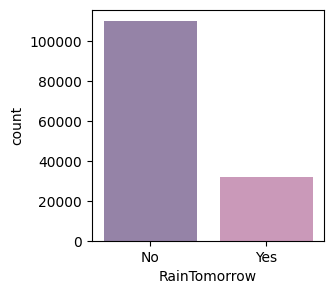

In [6]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
sns.countplot(x=data["RainTomorrow"], palette=colors)
plt.show()

In [7]:
class_0_samples = data[data['RainTomorrow'] == 'No']
class_1_samples = data[data['RainTomorrow'] == 'Yes']

# numero de muestras en cada clase
num_class_0_samples = len(class_0_samples)
num_class_1_samples = len(class_1_samples)

# ratio para balanceo
desired_ratio = 1

# clase 1 se mantiene
desired_num_samples_class_1 = num_class_1_samples

# muestras para clase 2
desired_num_samples_class_0 = desired_ratio * desired_num_samples_class_1
keep_ratio = desired_num_samples_class_0 / num_class_0_samples
class_0_samples_balanced = class_0_samples.sample(frac=keep_ratio, random_state=42)

data = pd.concat([class_0_samples_balanced, class_1_samples])
data = data.sample(frac=1, random_state=42)

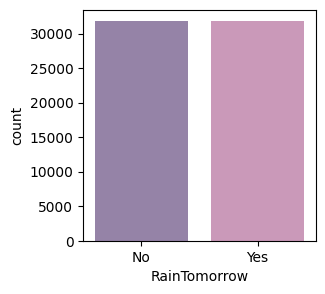

In [8]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
sns.countplot(x=data["RainTomorrow"], palette=colors)
plt.show()

### Matriz de correlación

Las variables cuyo valor de correlación se acerque más a 1, pueden llegar a ser redundantes en el modelo. En este caso, se optó por eliminar las features 'Temp9am' y 'Temp3pm' debido al análisis del heat map y a prueba y error de las mejores combinaciones.

<Axes: >

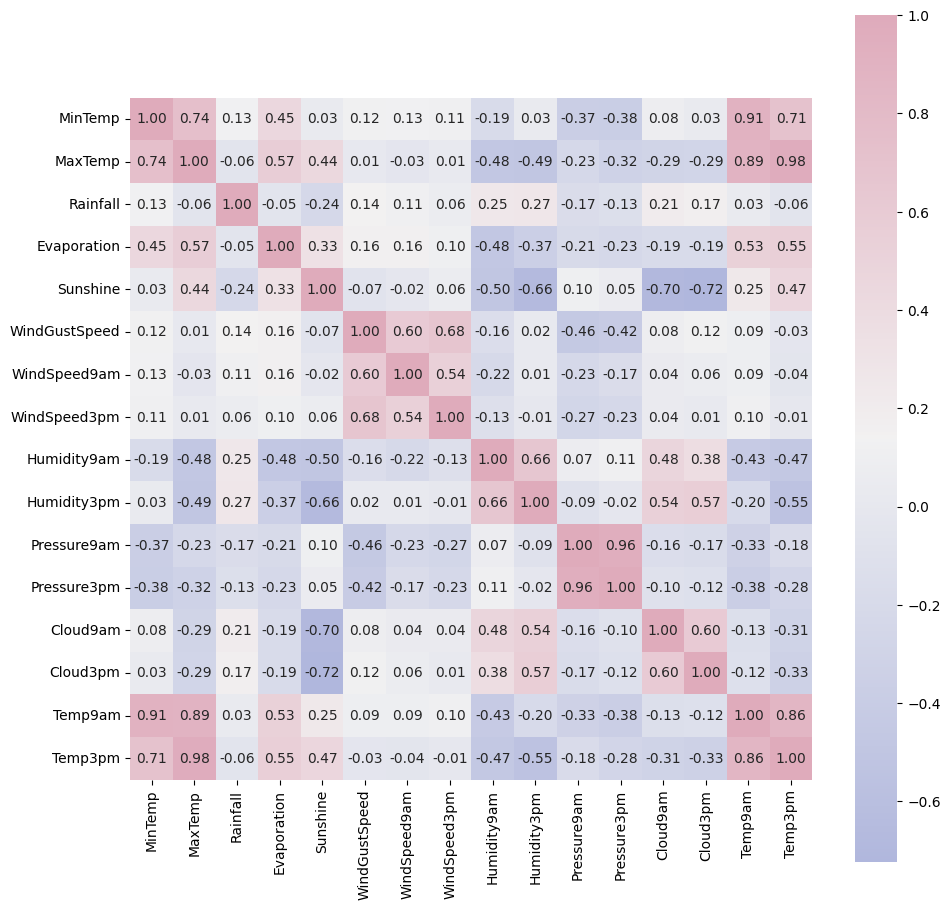

In [9]:
corrmat = data.corr(numeric_only=True)
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(11,11))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True, fmt='.2f')

### Parseando feature "Date" de manera cíclica

Text(0.5, 0, 'seno')

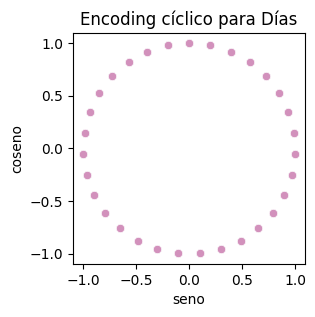

In [10]:
data['Date']= pd.to_datetime(data["Date"])  # convertir en datetime
data['year'] = data.Date.dt.year # nueva columna extrayendo el año

# encoding para datos con comportamiento cíclico (mes y día)
def cyclic_encoding(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = cyclic_encoding(data, 'month', 12)

data['day'] = data.Date.dt.day
data = cyclic_encoding(data, 'day', 31)

plt.figure(figsize=(3, 3))
cyclic_day = sns.scatterplot(x='day_sin', y='day_cos' ,data=data, color="#D291BC")
cyclic_day.set_title("Encoding cíclico para Días")
cyclic_day.set_ylabel("coseno")
cyclic_day.set_xlabel("seno")

### División set de Training / Test


In [11]:
data['RainTomorrow'] = data['RainTomorrow'].replace({'Yes': 1, 'No': 0})
data['RainTomorrow'] = imputer_mode.fit_transform(data[['RainTomorrow']])

target = data['RainTomorrow']
features = data.drop(['RainTomorrow', 'Date', 'day', 'month', 'Temp9am', 'Temp3pm'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

### Valores nulos - Variables numéricas

In [12]:
# variables numéricas
nums = (X_train.dtypes == "float64") | (X_train.dtypes == "int64")
numerical = list(nums[nums].index)

# reemplazar nulos por mediana de columna respectiva
X_train[numerical] = imputer_median.fit_transform(X_train[numerical])
X_test[numerical] = imputer_median.transform(X_test[numerical])

# visualizar total de valores nulos
null_counts = X_train[numerical].apply(lambda x: x.isnull().sum())
print(null_counts)

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
year             0
month_sin        0
month_cos        0
day_sin          0
day_cos          0
dtype: int64


### Valores nulos - Variables categóricas

In [13]:
# variables categóricas
objs = (X_train.dtypes == "object")
categories = list(objs[objs].index)

# reemplazar nulos por moda de columna respectiva
X_train[categories] = imputer_mode.fit_transform(X_train[categories])
X_test[categories] = imputer_mode.transform(X_test[categories])

# visualizar total de valores nulos
null_counts = X_train[categories].apply(lambda x: x.isnull().sum())
print(null_counts)

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64


### Encoding de strings a valores numéricos

In [14]:
label_encoder = LabelEncoder()

combined_data = pd.concat([X_train, X_test], axis=0)
combined_data[categories] = combined_data[categories].apply(lambda col: label_encoder.fit_transform(col))

X_train = combined_data.iloc[:len(X_train)]
X_test = combined_data.iloc[len(X_train):]

### Normalización

In [15]:
# reset indices to StandardScaler doesn't mismatch them
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

s_scaler = StandardScaler()

col_names = list(combined_data.columns)

X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

indices_match = X_train.index.equals(y_train.index) and X_test.index.equals(y_test.index)

if indices_match:
    print("Indices match.")
else:
    print("Indices do not match.")

Indices match.


### Análisis de Outliers / Caja de Bigotes


Gracias al diagrama de la Caja de Bigotes de Seaborn, los outliers pueden identificarse como los símbolos de diamantes. Se hará un análisis del rango intercuartil para eliminarlos.

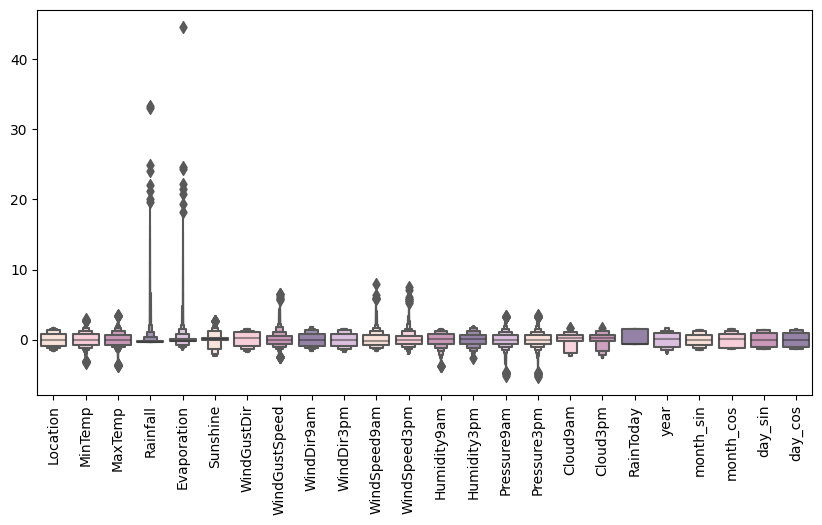

In [16]:
combined_data = pd.concat([X_train, X_test], axis=0)

colors = ["#FFDFD3", "#FEC8D8", "#D291BC", "#957DAD", "#E0BBE4"]
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

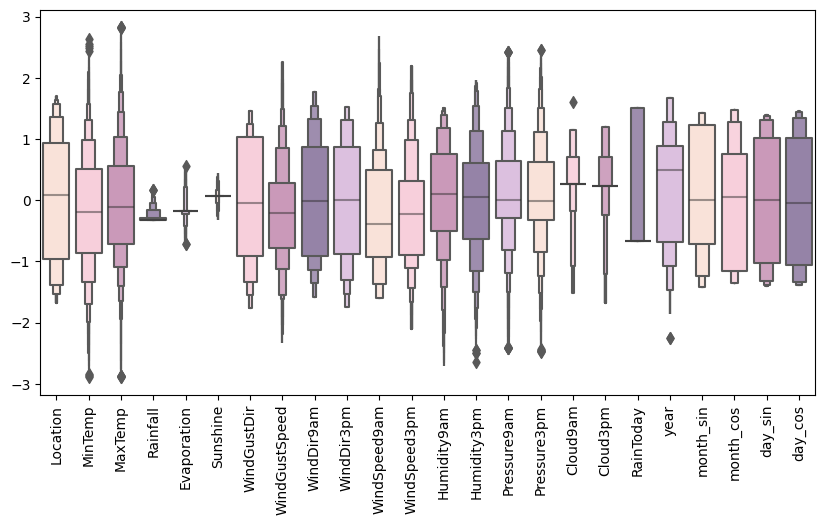

In [17]:
# funcion para eliminar outliers
def remove_outliers(dataframe, X_train, X_test, y_train, y_test, column, multiplier=1.5):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - (IQR * multiplier)
    upper_fence = Q3 + (IQR * multiplier)

    mask_train = (X_train[column] >= lower_fence) & (X_train[column] <= upper_fence)
    mask_test = (X_test[column] >= lower_fence) & (X_test[column] <= upper_fence)

    cleaned_X_train = X_train[mask_train]
    cleaned_X_test = X_test[mask_test]

    cleaned_y_train = y_train[mask_train]
    cleaned_y_test = y_test[mask_test]

    return cleaned_X_train, cleaned_X_test, cleaned_y_train, cleaned_y_test

# features en las cuales se eliminaran outliers
features_to_remove_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
                               'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                               'Pressure3pm', 'Cloud9am', 'Cloud3pm']

X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

for feature in features_to_remove_outliers:
     X_train_clean, X_test_clean, y_train_clean, y_test_clean = remove_outliers(combined_data, X_train_clean, X_test_clean, y_train_clean, y_test_clean, feature)

combined_data_clean = pd.concat([X_train_clean, X_test_clean], axis=0)
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data_clean, palette = colors)
plt.xticks(rotation=90)
plt.show()

Se verifica la reducción en muestras

In [18]:
print(len(X_train))
print(len(X_train_clean))
print(len(y_train))
print(len(y_train_clean))

44627
15101
44627
15101


## Regresión Logística

### Entrenamiento


Se entrenarán dos modelos, uno con el dataset sin outliers y otro con outliers. Esto para mostrar las diferencias en métricas en ambos casos.

In [ ]:
# con outliers
our_logreg = OurLogisticRegression(0.15, 20000)
our_logreg.fit(X_train, y_train)

# sin outliers
our_logreg_clean = OurLogisticRegression(0.15, 20000)
our_logreg_clean.fit(X_train_clean, y_train_clean)

### Testing

In [ ]:
# con outliers
y_pred_logreg = our_logreg.predict(X_test, threshold=0.5)
y_pred_train_logreg = our_logreg.predict(X_train, threshold=0.5)
y_prob_logreg = our_logreg.predict_prob(X_test)

# sin outliers
y_pred_logreg_clean = our_logreg_clean.predict(X_test_clean, threshold=0.5)
y_pred_train_logreg_clean = our_logreg_clean.predict(X_train_clean, threshold=0.5)
y_prob_logreg_clean = our_logreg_clean.predict_prob(X_test_clean)

### Métricas y Análisis Inicial

Para ambos casos, no se observa overfitting ni underfitting, ya que los valores de accuracy, precision, recall y F1 score se mantienen en rangos sumamente similares tanto en el entrenamiento como e el testeo.

Aunque, es notable que al utilizar el dataset con outliers, se obtienen mejores métricas. Esto se puede explicar con la posibilidad de que los outliers sean datos sí atípicos, pero igualmente importantes para el modelo. Es decir, son mediciones que aún así son válidas y deben tomarse en cuenta.

Para este modelo, se considera que los Falsos Negativos deben minimizarse, ya que es más crítico predecir que no va a llover cuando en realidad sí lo hace. En otras palabras, se quieren minimizar los errores de Tipo 2 por sobre los Tipo 1. Sin embargo, los errores Tipo 1 también son importantes. Al observar la métrica de F1, se obtiene un balance muy bueno entre precision y recall, lo que es ideal.

In [ ]:
# accuracy, precision, recall, f1

# con outliers
our_logreg_train_accuracy = accuracy_score(y_train, y_pred_train_logreg)
our_logreg_train_precision = precision_score(y_train, y_pred_train_logreg)
our_logreg_train_recall = recall_score(y_train, y_pred_train_logreg)
our_logreg_train_f1 = f1_score(y_train, y_pred_train_logreg)

our_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
our_logreg_precision = precision_score(y_test, y_pred_logreg)
our_logreg_recall = recall_score(y_test, y_pred_logreg)
our_logreg_f1 = f1_score(y_test, y_pred_logreg)

# sin outliers
our_logreg_train_accuracy_clean = accuracy_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_precision_clean = precision_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_recall_clean = recall_score(y_train_clean, y_pred_train_logreg_clean)
our_logreg_train_f1_clean = f1_score(y_train_clean, y_pred_train_logreg_clean)

our_logreg_accuracy_clean = accuracy_score(y_test_clean, y_pred_logreg_clean)
our_logreg_precision_clean = precision_score(y_test_clean, y_pred_logreg_clean)
our_logreg_recall_clean = recall_score(y_test_clean, y_pred_logreg_clean)
our_logreg_f1_clean = f1_score(y_test_clean, y_pred_logreg_clean)

print("----- DATASET CON OUTLIERS -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1))
print("\n")

print("----- DATASET SIN OUTLIERS -----")
print('Our training accuracy:  {0:0.8f}'. format(our_logreg_train_accuracy_clean))
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision_clean))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall_clean))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1_clean))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_accuracy_clean))
print('Our test precision: {0:0.8f}'. format(our_logreg_precision_clean))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall_clean))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1_clean))

----- DATASET CON OUTLIERS -----
Our training accuracy:  0.77639097
Our training precision: 0.78147962
Our training recall:    0.76736578
Our training F1:        0.77435839


Our test accuracy:  0.78057197
Our test precision: 0.78421610
Our test recall:    0.77412946
Our test F1:        0.77914014


----- DATASET SIN OUTLIERS -----
Our training accuracy:  0.74041454
Our training precision: 0.73458529
Our training recall:    0.67851980
Our training F1:        0.70544034


Our test accuracy:  0.74212297
Our test precision: 0.73395150
Our test recall:    0.68645764
Our test F1:        0.70941055


La matriz de confusión para el dataset con outliers muestra que la cantidad de Falsos Negativos (FN), es decir, la clasificación de observaciones reales de que va a llover, es mucho menor a la cantidad de VN. Lo mismo se cumple para los Falsos Positivos. Estos buenos resultados se dan debido a la eliminación del sesgo en el dataset, ya que el modelo logra discernir relativamente bien entre ambas clases.

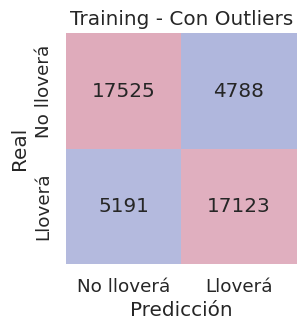

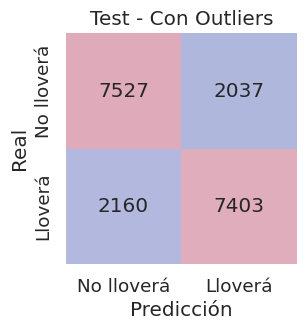

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train_logreg)
cm_test = confusion_matrix(y_test, y_pred_logreg)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Con Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Con Outliers')
plt.show()

El AUC da un valor bastante alto, lo que implica que el modelo es bueno en su capacidad de separar los eventos de lluvia de los eventos sin lluvia. Un AUC = 1 es el ideal, por lo que entonces el valor obtenido es bastante bueno.

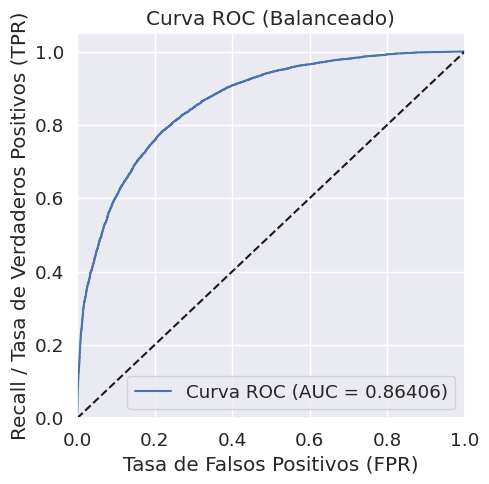

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetros

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.10, 0.5, log=True)
    num_iter = trial.suggest_int('num_iter', 20000, 40000)

    model = OurLogisticRegression(lr=lr, num_iter=num_iter)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test, threshold=0.5)

    # métrica a optimizar
    F1 = f1_score(y_test, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-02 19:57:16,341] A new study created in memory with name: no-name-7cbceb0e-77fe-433a-b525-784f13005a64
[I 2023-10-02 19:59:01,909] Trial 0 finished with value: 0.7791401357680368 and parameters: {'lr': 0.31882347121900806, 'num_iter': 34885}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:01:14,515] Trial 1 finished with value: 0.7791401357680368 and parameters: {'lr': 0.11850321542949332, 'num_iter': 38940}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:02:32,341] Trial 2 finished with value: 0.7791401357680368 and parameters: {'lr': 0.40394621169672584, 'num_iter': 28654}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:04:15,458] Trial 3 finished with value: 0.7791401357680368 and parameters: {'lr': 0.15170465021452506, 'num_iter': 34301}. Best is trial 0 with value: 0.7791401357680368.
[I 2023-10-02 20:05:19,041] Trial 4 finished with value: 0.7791401357680368 and parameters: {'lr': 0.15124814471257825, 'num_iter': 22

### Resultados finales - Ajuste de Umbral

Por último, se probarán distintos umbrales para mejorar el F1 score y por lo tanto el recall.

In [ ]:
our_logreg = OurLogisticRegression(best_params['lr'], best_params['num_iter'])
our_logreg.fit(X_train, y_train)
y_prob_logreg = our_logreg.predict_prob(X_test)

# umbrales a probar
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_prob_logreg > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

y_pred_best = (y_prob_logreg > best_threshold).astype(int)

# accuracy, precision, recall, f1
our_logreg_reg_accuracy = accuracy_score(y_test, y_pred_best)
our_logreg_reg_precision = precision_score(y_test, y_pred_best)
our_logreg_reg_recall = recall_score(y_test, y_pred_best)
our_logreg_reg_f1 = f1_score(y_test, y_pred_best)

print('Our accuracy:  {0:0.8f}'. format(our_logreg_reg_accuracy))
print('Our precision: {0:0.8f}'. format(our_logreg_reg_precision))
print('Our recall:    {0:0.8f}'. format(our_logreg_reg_recall))
print('Our F1:        {0:0.8f}'. format(our_logreg_reg_f1))

Our accuracy:  0.76969729
Our precision: 0.72524017
Our recall:    0.86834675
Our F1:        0.79036787


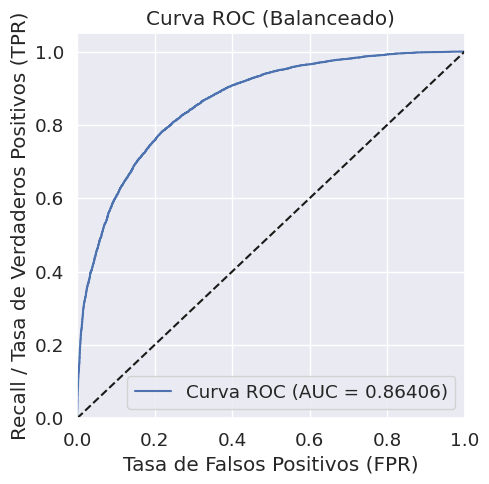

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Comparación con sklearn

In [ ]:
skleran_logreg = LogisticRegression(random_state=42)
skleran_logreg.fit(X_train, y_train)
skleran_logreg_pred = skleran_logreg.predict(X_test)
sklearn_y_proba = skleran_logreg.predict_proba(X_test)[:, 1]

sklearn_logreg_accuracy = accuracy_score(y_test, skleran_logreg_pred)
sklearn_logreg_precision = precision_score(y_test, skleran_logreg_pred)
sklearn_logreg_recall = recall_score(y_test, skleran_logreg_pred)
sklearn_logreg_f1 = f1_score(y_test, skleran_logreg_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_logreg_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_logreg_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_logreg_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_logreg_f1))

sklearn accuracy:  0.78062425
sklearn precision: 0.78423896
sklearn recall:    0.77423403
sklearn F1:        0.77920438


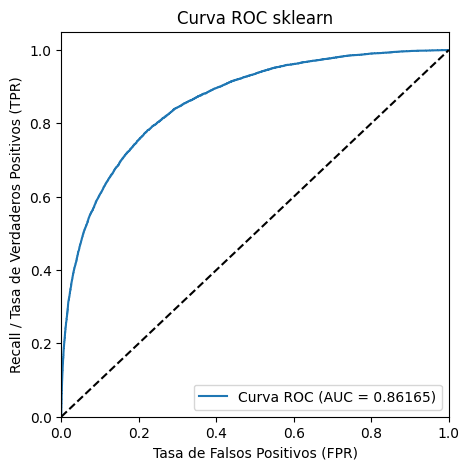

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, sklearn_y_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## K-Nearest Neighbors

Para este algoritmo y el de árboles de decisión, se entrenará únicamente con el dataset con outliers, ya que anteriormente se comprobó que este brinda resultados mejores.
Se debe cambiar de DataFrame a numpy array, debido a que es el tipo de dato que manejan de buena manera OurKNearest y OurDecisionTree.

Para KNN, se utiliza el dataset sin outliers debido a que si se usa el dataset con outliers, sufrimos de insuficiencia de memoria.

In [32]:
X_test_np = X_test_clean.to_numpy()
y_test_np = y_test_clean.to_numpy()

X_train_np = X_train_clean.to_numpy()
y_train_np = y_train_clean.to_numpy()

### Entrenamiento

In [38]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=5, weights='distance', n_classes=2, distance='minkowski', p=0.8)

### Testing

In [39]:
y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

### Métricas y Análisis Inicial

Con las métricas obtenidas, se observa que hay un poco de overfitting debido a que las métricas del testing no son tan buenas como las de training.

In [40]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)


print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.82100523
Our train precision: 0.82750583
Our train recall:    0.76973114
Our train F1:        0.79757358


Our test accuracy:  0.73569899
Our test precision: 0.73553412
Our test recall:    0.66144096
Our test F1:        0.69652266


Con la matriz de confusión, se muestra que el modelo logra clasificar correctamente la mayoría de los datos. Igualmente posee FN y FP, pero en una medida mucho menor que sus contrapartes verdaderos.

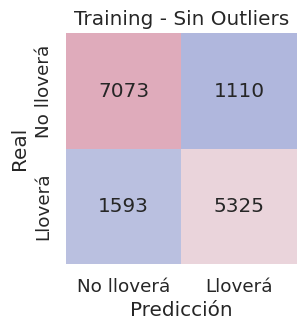

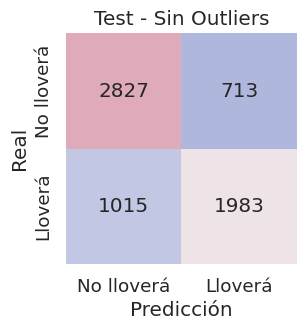

In [41]:
# confusion matrix
cm_train = confusion_matrix(y_train_np, y_pred_knn_train)
cm_test = confusion_matrix(y_test_np, y_pred_knn)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sin Outliers')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sin Outliers')
plt.show()

La gráfica ROC y el valor de AUC muestran que este modelo de KNN no es uno muy bueno, y tiene problemas para clasificar y diferenciar entre ambas clases. Esto puede ser debido a que KNN es uno de fuerza bruta, y no tan especializado como lo es la regresión logística.

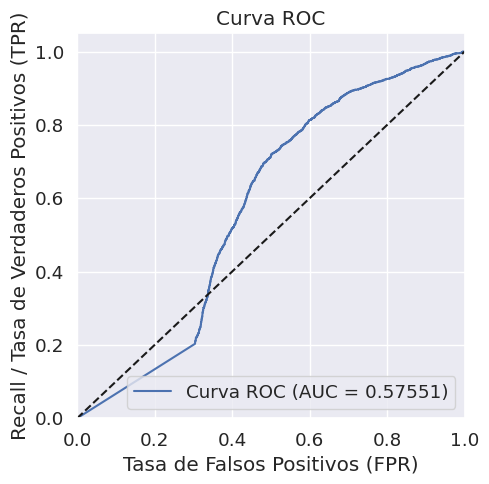

In [42]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetro (k)

In [44]:
def objective(trial):
    k = trial.suggest_int('k', 5, 50)

    model = OurKNearest(X_train_np, y_train_np, n_neighbors=k, weights='distance', n_classes=2, distance='minkowski', p=0.8)

    y_pred = our_knn.predict(X_test_np, return_prob=False)

    # métrica a optimizar
    F1 = f1_score(y_test_np, y_pred)

    return F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-10-03 00:17:23,765] A new study created in memory with name: no-name-faec3956-af71-495f-93d4-1a51ea712585
[I 2023-10-03 00:19:17,789] Trial 0 finished with value: 0.6965226554267651 and parameters: {'k': 36}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 00:20:52,258] Trial 1 finished with value: 0.6965226554267651 and parameters: {'k': 11}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 00:22:39,856] Trial 2 finished with value: 0.6965226554267651 and parameters: {'k': 49}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 00:24:31,294] Trial 3 finished with value: 0.6965226554267651 and parameters: {'k': 18}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 00:26:13,486] Trial 4 finished with value: 0.6965226554267651 and parameters: {'k': 27}. Best is trial 0 with value: 0.6965226554267651.
[I 2023-10-03 00:27:51,963] Trial 5 finished with value: 0.6965226554267651 and parameters: {'k': 50}. Best is trial 0 with value: 

### Resultados finales

Gracias al ajuste del parámetro k, se logró una mejoría bastante considerable en las métricas, así como eliminar el overfitting.
El AUC ahora es un muy buen valor, lo que implica que escoger un valor bueno de k neighbors es crucial para este algoritmo.

In [45]:
our_knn = OurKNearest(X_train_np, y_train_np, n_neighbors=best_params['k'], weights='distance', n_classes=2, distance='minkowski', p=0.8)

y_pred_knn_train = our_knn.predict(X_train_np, return_prob=False)
y_pred_knn, y_prob_knn = our_knn.predict(X_test_np)

In [46]:
our_knn_accuracy_train = accuracy_score(y_train_np, y_pred_knn_train)
our_knn_precision_train = precision_score(y_train_np, y_pred_knn_train)
our_knn_recall_train = recall_score(y_train_np, y_pred_knn_train)
our_knn_f1_train = f1_score(y_train_np, y_pred_knn_train)

our_knn_accuracy = accuracy_score(y_test_np, y_pred_knn)
our_knn_precision = precision_score(y_test_np, y_pred_knn)
our_knn_recall = recall_score(y_test_np, y_pred_knn)
our_knn_f1 = f1_score(y_test_np, y_pred_knn)


print('Our train accuracy:  {0:0.8f}'. format(our_knn_accuracy_train))
print('Our train precision: {0:0.8f}'. format(our_knn_precision_train))
print('Our train recall:    {0:0.8f}'. format(our_knn_recall_train))
print('Our train F1:        {0:0.8f}'. format(our_knn_f1_train))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_knn_accuracy))
print('Our test precision: {0:0.8f}'. format(our_knn_precision))
print('Our test recall:    {0:0.8f}'. format(our_knn_recall))
print('Our test F1:        {0:0.8f}'. format(our_knn_f1))

Our train accuracy:  0.75398980
Our train precision: 0.78450879
Our train recall:    0.63833478
Our train F1:        0.70391329


Our test accuracy:  0.73799327
Our test precision: 0.76407727
Our test recall:    0.62008005
Our test F1:        0.68458847


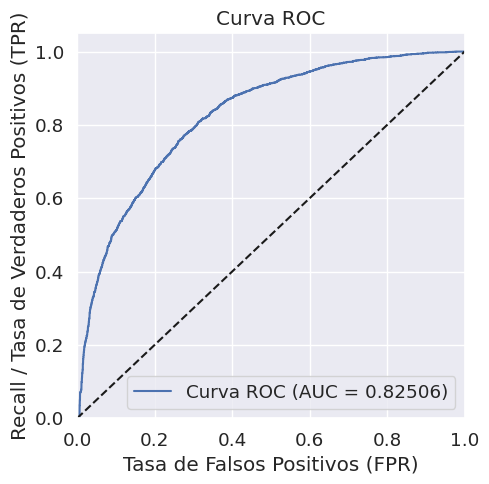

In [47]:
fpr, tpr, thresholds = roc_curve(y_test_np, y_prob_knn[:, 1])
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Árboles de Decisión

### Entrenamiento

In [ ]:
tree = Node(max_depth=3)
tree.fit(X_train_np, y_train_np)

### Testing

In [ ]:
y_pred_tree = [tree.predict(x) for x in X_test_np]

### Métricas y Análisis Inicial

In [ ]:
our_tree_accuracy = accuracy_score(y_test_np, y_pred_tree)
our_tree_precision = precision_score(y_test_np, y_pred_tree)
our_tree_recall = recall_score(y_test_np, y_pred_tree)
our_tree_f1 = f1_score(y_test_np, y_pred_tree)

print('Our test accuracy:  {0:0.8f}'. format(our_tree_accuracy))
print('Our test precision: {0:0.8f}'. format(our_tree_precision))
print('Our test recall:    {0:0.8f}'. format(our_tree_recall))
print('Our test F1:        {0:0.8f}'. format(our_tree_f1))